In [3]:
import numpy as np
import torch
import os
import net
import utils
from PIL import Image
from tqdm import tqdm
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from time import time
import pickle
import random
from pathlib import Path

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [4]:
BATCH_SIZE = 16
DS_FOLDER = "/home/ML_courses/03683533_2021/dataset"
LR = 1e-4
DEVICE_ID = 0
VAL_RANGE = 1000
TRAIN_RANGE = None
NUM_WORKERS = 16
NUM_EPOCHS = 20
SHUFFLE = True
RUN_NAME = 'Alex-MSE-tanh-batch16-shuffled'

# Network and optimizer

In [6]:
model = net.AutoEncoder(activation='leaky_r',last_activation='tanh')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
device = f'cuda:{DEVICE_ID}' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda:0


AutoEncoder(
  (activation): LeakyReLU(negative_slope=0.01)
  (last_activation): Tanh()
  (enc1): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(4, 4))
  (enc1_bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc2): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (enc2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1))
  (enc3_bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1))
  (enc4_bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc5_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

# Data Loader & Dataset

In [7]:
transform = transforms.Compose([transforms.Resize(256),
                                transforms.ToTensor(),
                                ])

class UniDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = Image.open(image_path)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.image_paths)

In [8]:
val_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[:VAL_RANGE]]
if TRAIN_RANGE != None:
    train_files = [os.path.join(DS_FOLDER,i) for i in 
                   sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:TRAIN_RANGE+1+VAL_RANGE]]
else:
    train_files = [os.path.join(DS_FOLDER,i) for i in sorted(os.listdir(DS_FOLDER))[VAL_RANGE+1:]]

In [9]:
val_ds = UniDataset(val_files, transform=transform)
train_ds = UniDataset(train_files, transform=transform)

In [10]:
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True, shuffle=SHUFFLE)

# Train model

In [11]:
def save_imgs(true_imgs, val_imgs, dirname, epoch):
    path = os.path.join('results', RUN_NAME, epoch)
    os.makedirs(path, exist_ok=True)
    save_image(val_imgs, os.path.join(path, 'val_pred.png'))
    save_image(true_imgs, os.path.join(path, 'val_true.png'))

In [12]:
def calc_val_loss(val_dl, epoch, dirname):
    with torch.no_grad():
        val_loss = 0.0
        for images in val_dl:
            images = images.float().to(device)
            outputs = model(images)
            images.require_grad = False
            loss = criterion(outputs, images)
            val_loss += loss.item()
    images = images.cpu()
    outputs = outputs.view(outputs.size(0), 3, 256, 256).cpu().data
    save_imgs(images, outputs, dirname, epoch)
    return val_loss/len(val_dl), make_grid(images), make_grid(outputs)

In [13]:
%%time

train_losses = {}
val_losses = {}
for epoch in range(1, NUM_EPOCHS+1):
    t = time()
    train_loss = 0.0
    for images in tqdm(train_dl):
        images = images.float()
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    val_loss, val_true_grid, val_pred_grid = calc_val_loss(val_dl, str(epoch), RUN_NAME)
    train_loss = train_loss/len(train_dl)
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    print('Epoch: {} \tTraining Loss: {:.6f} \tVal Loss: {:.6f}\t \
    in time {:2f}m'.format(epoch, train_loss, val_loss, (time()-t)/60))


100%|███████████████████████████████████████| 2438/2438 [02:28<00:00, 16.44it/s]


Epoch: 1 	Training Loss: 0.045558 	Val Loss: 0.011244	     in time 2.514444m


100%|███████████████████████████████████████| 2438/2438 [02:29<00:00, 16.34it/s]


Epoch: 2 	Training Loss: 0.007814 	Val Loss: 0.006696	     in time 2.528423m


100%|███████████████████████████████████████| 2438/2438 [02:29<00:00, 16.30it/s]


Epoch: 3 	Training Loss: 0.005779 	Val Loss: 0.005250	     in time 2.534540m


100%|███████████████████████████████████████| 2438/2438 [02:30<00:00, 16.17it/s]


Epoch: 4 	Training Loss: 0.005078 	Val Loss: 0.004870	     in time 2.555708m


100%|███████████████████████████████████████| 2438/2438 [02:31<00:00, 16.14it/s]


Epoch: 5 	Training Loss: 0.004648 	Val Loss: 0.004648	     in time 2.559184m


100%|███████████████████████████████████████| 2438/2438 [02:31<00:00, 16.14it/s]


Epoch: 6 	Training Loss: 0.004404 	Val Loss: 0.004444	     in time 2.560824m


100%|███████████████████████████████████████| 2438/2438 [02:38<00:00, 15.37it/s]


Epoch: 7 	Training Loss: 0.004239 	Val Loss: 0.004044	     in time 2.686529m


100%|███████████████████████████████████████| 2438/2438 [02:37<00:00, 15.51it/s]


Epoch: 8 	Training Loss: 0.004100 	Val Loss: 0.003950	     in time 2.661998m


100%|███████████████████████████████████████| 2438/2438 [02:34<00:00, 15.83it/s]


Epoch: 9 	Training Loss: 0.003960 	Val Loss: 0.003856	     in time 2.609265m


100%|███████████████████████████████████████| 2438/2438 [02:32<00:00, 15.97it/s]


Epoch: 10 	Training Loss: 0.003841 	Val Loss: 0.003900	     in time 2.586616m


100%|███████████████████████████████████████| 2438/2438 [02:31<00:00, 16.06it/s]


Epoch: 11 	Training Loss: 0.003774 	Val Loss: 0.003704	     in time 2.572771m


100%|███████████████████████████████████████| 2438/2438 [02:31<00:00, 16.09it/s]


Epoch: 12 	Training Loss: 0.003692 	Val Loss: 0.003633	     in time 2.569548m


100%|███████████████████████████████████████| 2438/2438 [02:41<00:00, 15.10it/s]


Epoch: 13 	Training Loss: 0.003606 	Val Loss: 0.003568	     in time 2.736257m


100%|███████████████████████████████████████| 2438/2438 [02:46<00:00, 14.61it/s]


Epoch: 14 	Training Loss: 0.003552 	Val Loss: 0.003478	     in time 2.826727m


100%|███████████████████████████████████████| 2438/2438 [02:49<00:00, 14.36it/s]


Epoch: 15 	Training Loss: 0.003503 	Val Loss: 0.003483	     in time 2.872350m


100%|███████████████████████████████████████| 2438/2438 [02:40<00:00, 15.24it/s]


Epoch: 16 	Training Loss: 0.003466 	Val Loss: 0.003453	     in time 2.709779m


100%|███████████████████████████████████████| 2438/2438 [02:36<00:00, 15.61it/s]


Epoch: 17 	Training Loss: 0.003428 	Val Loss: 0.003346	     in time 2.644213m


100%|███████████████████████████████████████| 2438/2438 [02:28<00:00, 16.43it/s]


Epoch: 18 	Training Loss: 0.003386 	Val Loss: 0.003620	     in time 2.516072m


100%|███████████████████████████████████████| 2438/2438 [02:32<00:00, 15.95it/s]


Epoch: 19 	Training Loss: 0.003351 	Val Loss: 0.003377	     in time 2.591706m


100%|███████████████████████████████████████| 2438/2438 [02:32<00:00, 16.04it/s]


Epoch: 20 	Training Loss: 0.003317 	Val Loss: 0.003274	     in time 2.577235m
CPU times: user 43min 33s, sys: 11min 51s, total: 55min 25s
Wall time: 52min 24s


# Results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


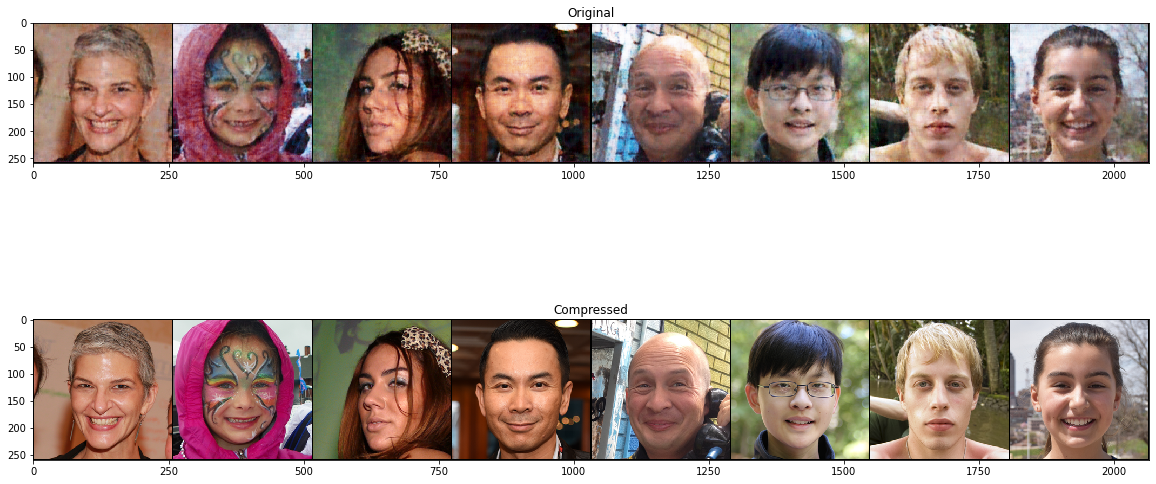

In [14]:
utils.show(val_true_grid, val_pred_grid)

In [15]:
path = Path("results") / RUN_NAME

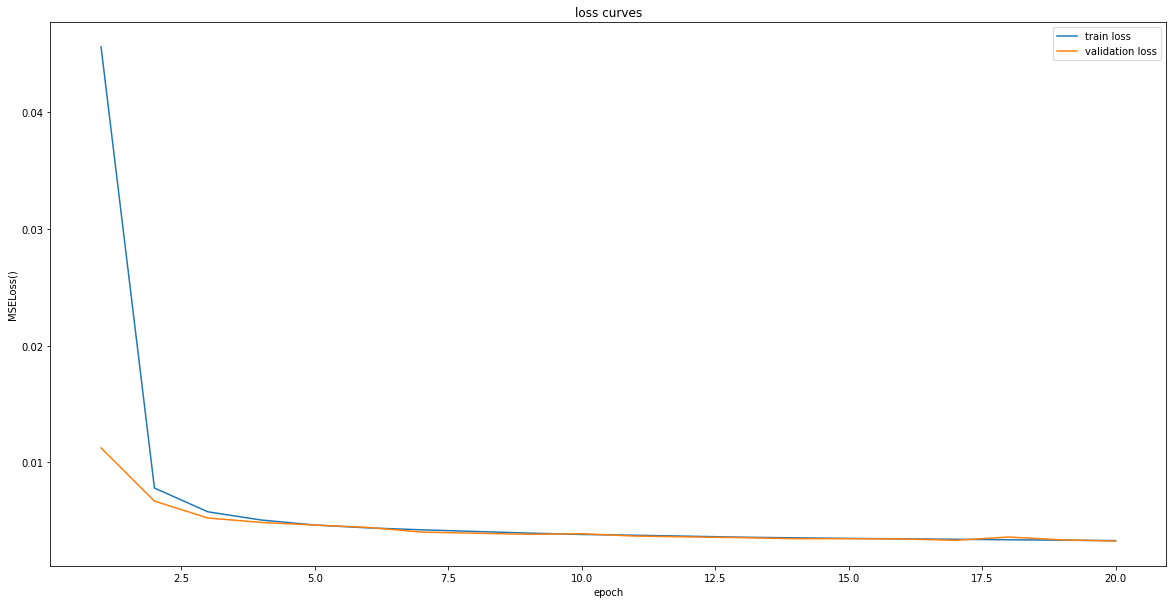

In [16]:
utils.plot_loss(criterion, train_losses, val_losses, path)

In [19]:
utils.write_losses(path, train_losses, val_losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


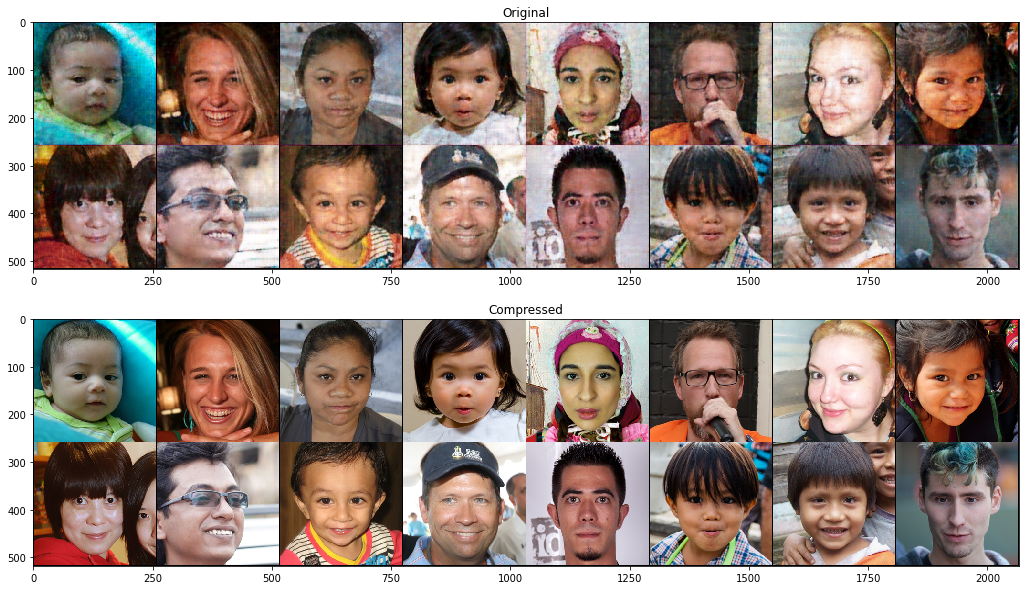

In [20]:
images = list(val_dl)[0]
outputs = model(images.to(device)).cpu()
utils.show(make_grid(images), make_grid(outputs), save=True, path=path)